# Где дешевле жить? Предсказание цен в Airbnb - учимся генерировать признаки и интерпретировать результаты модели

# Часть 1. EDA

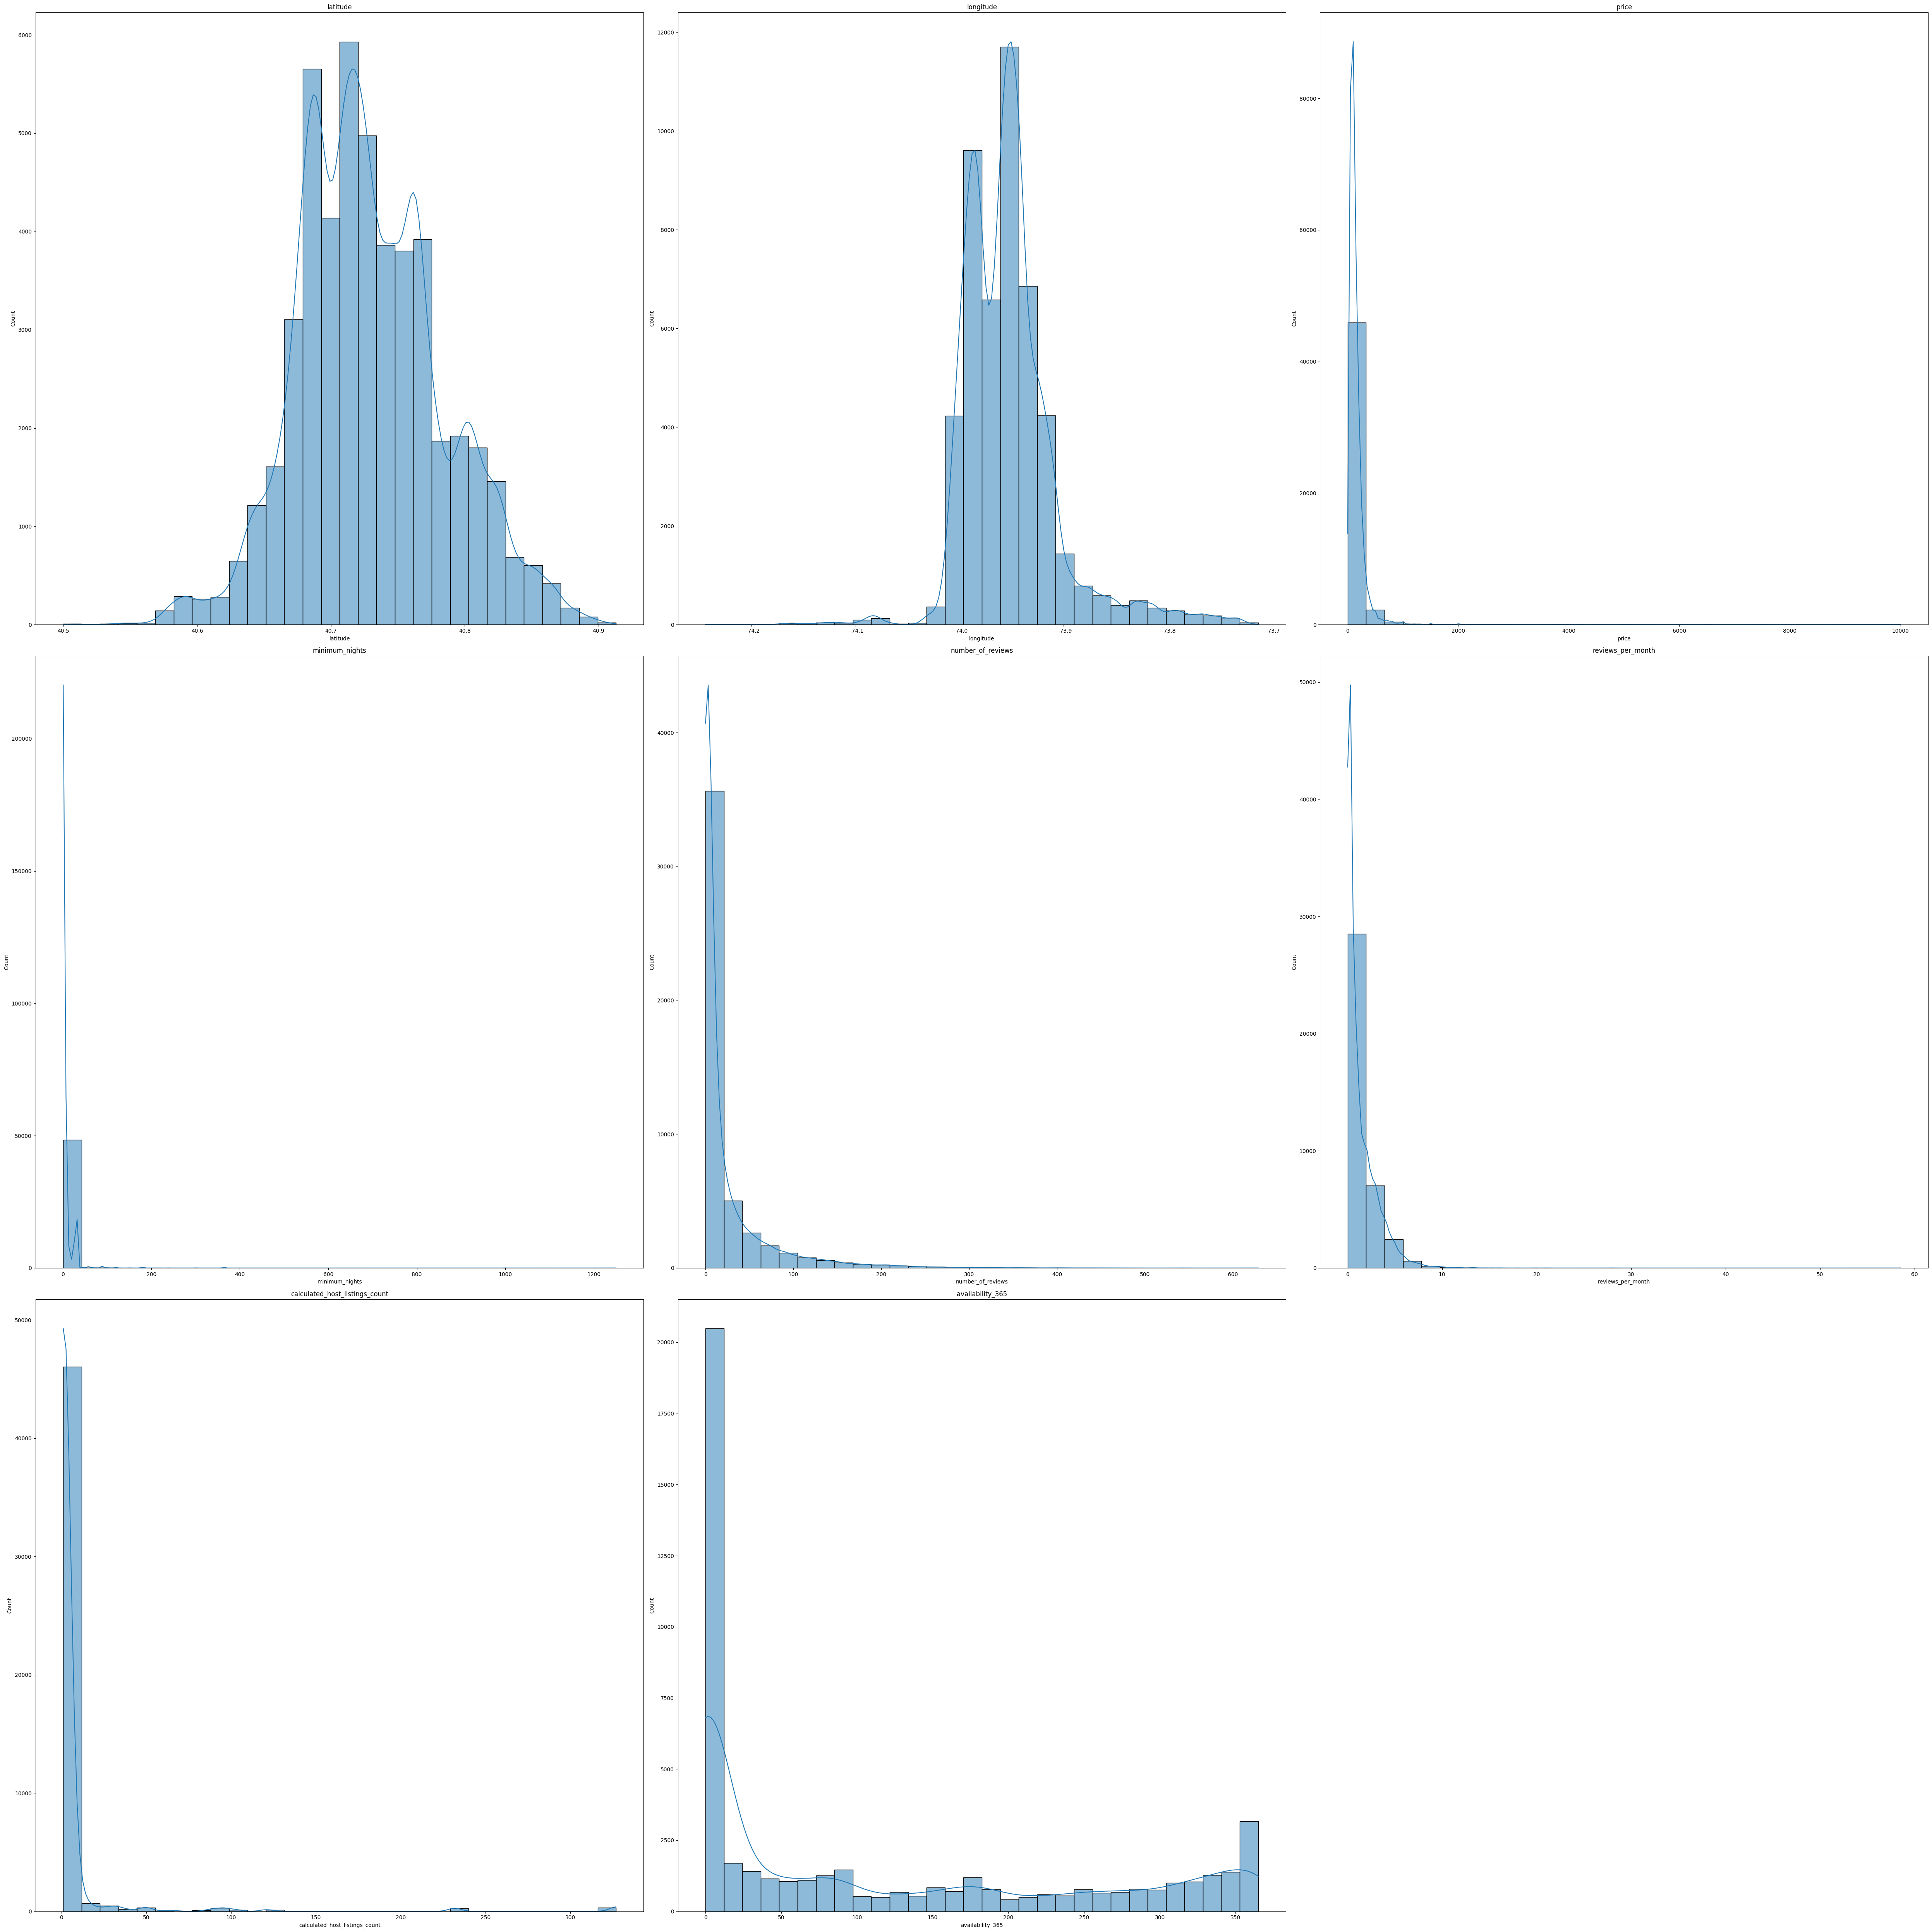

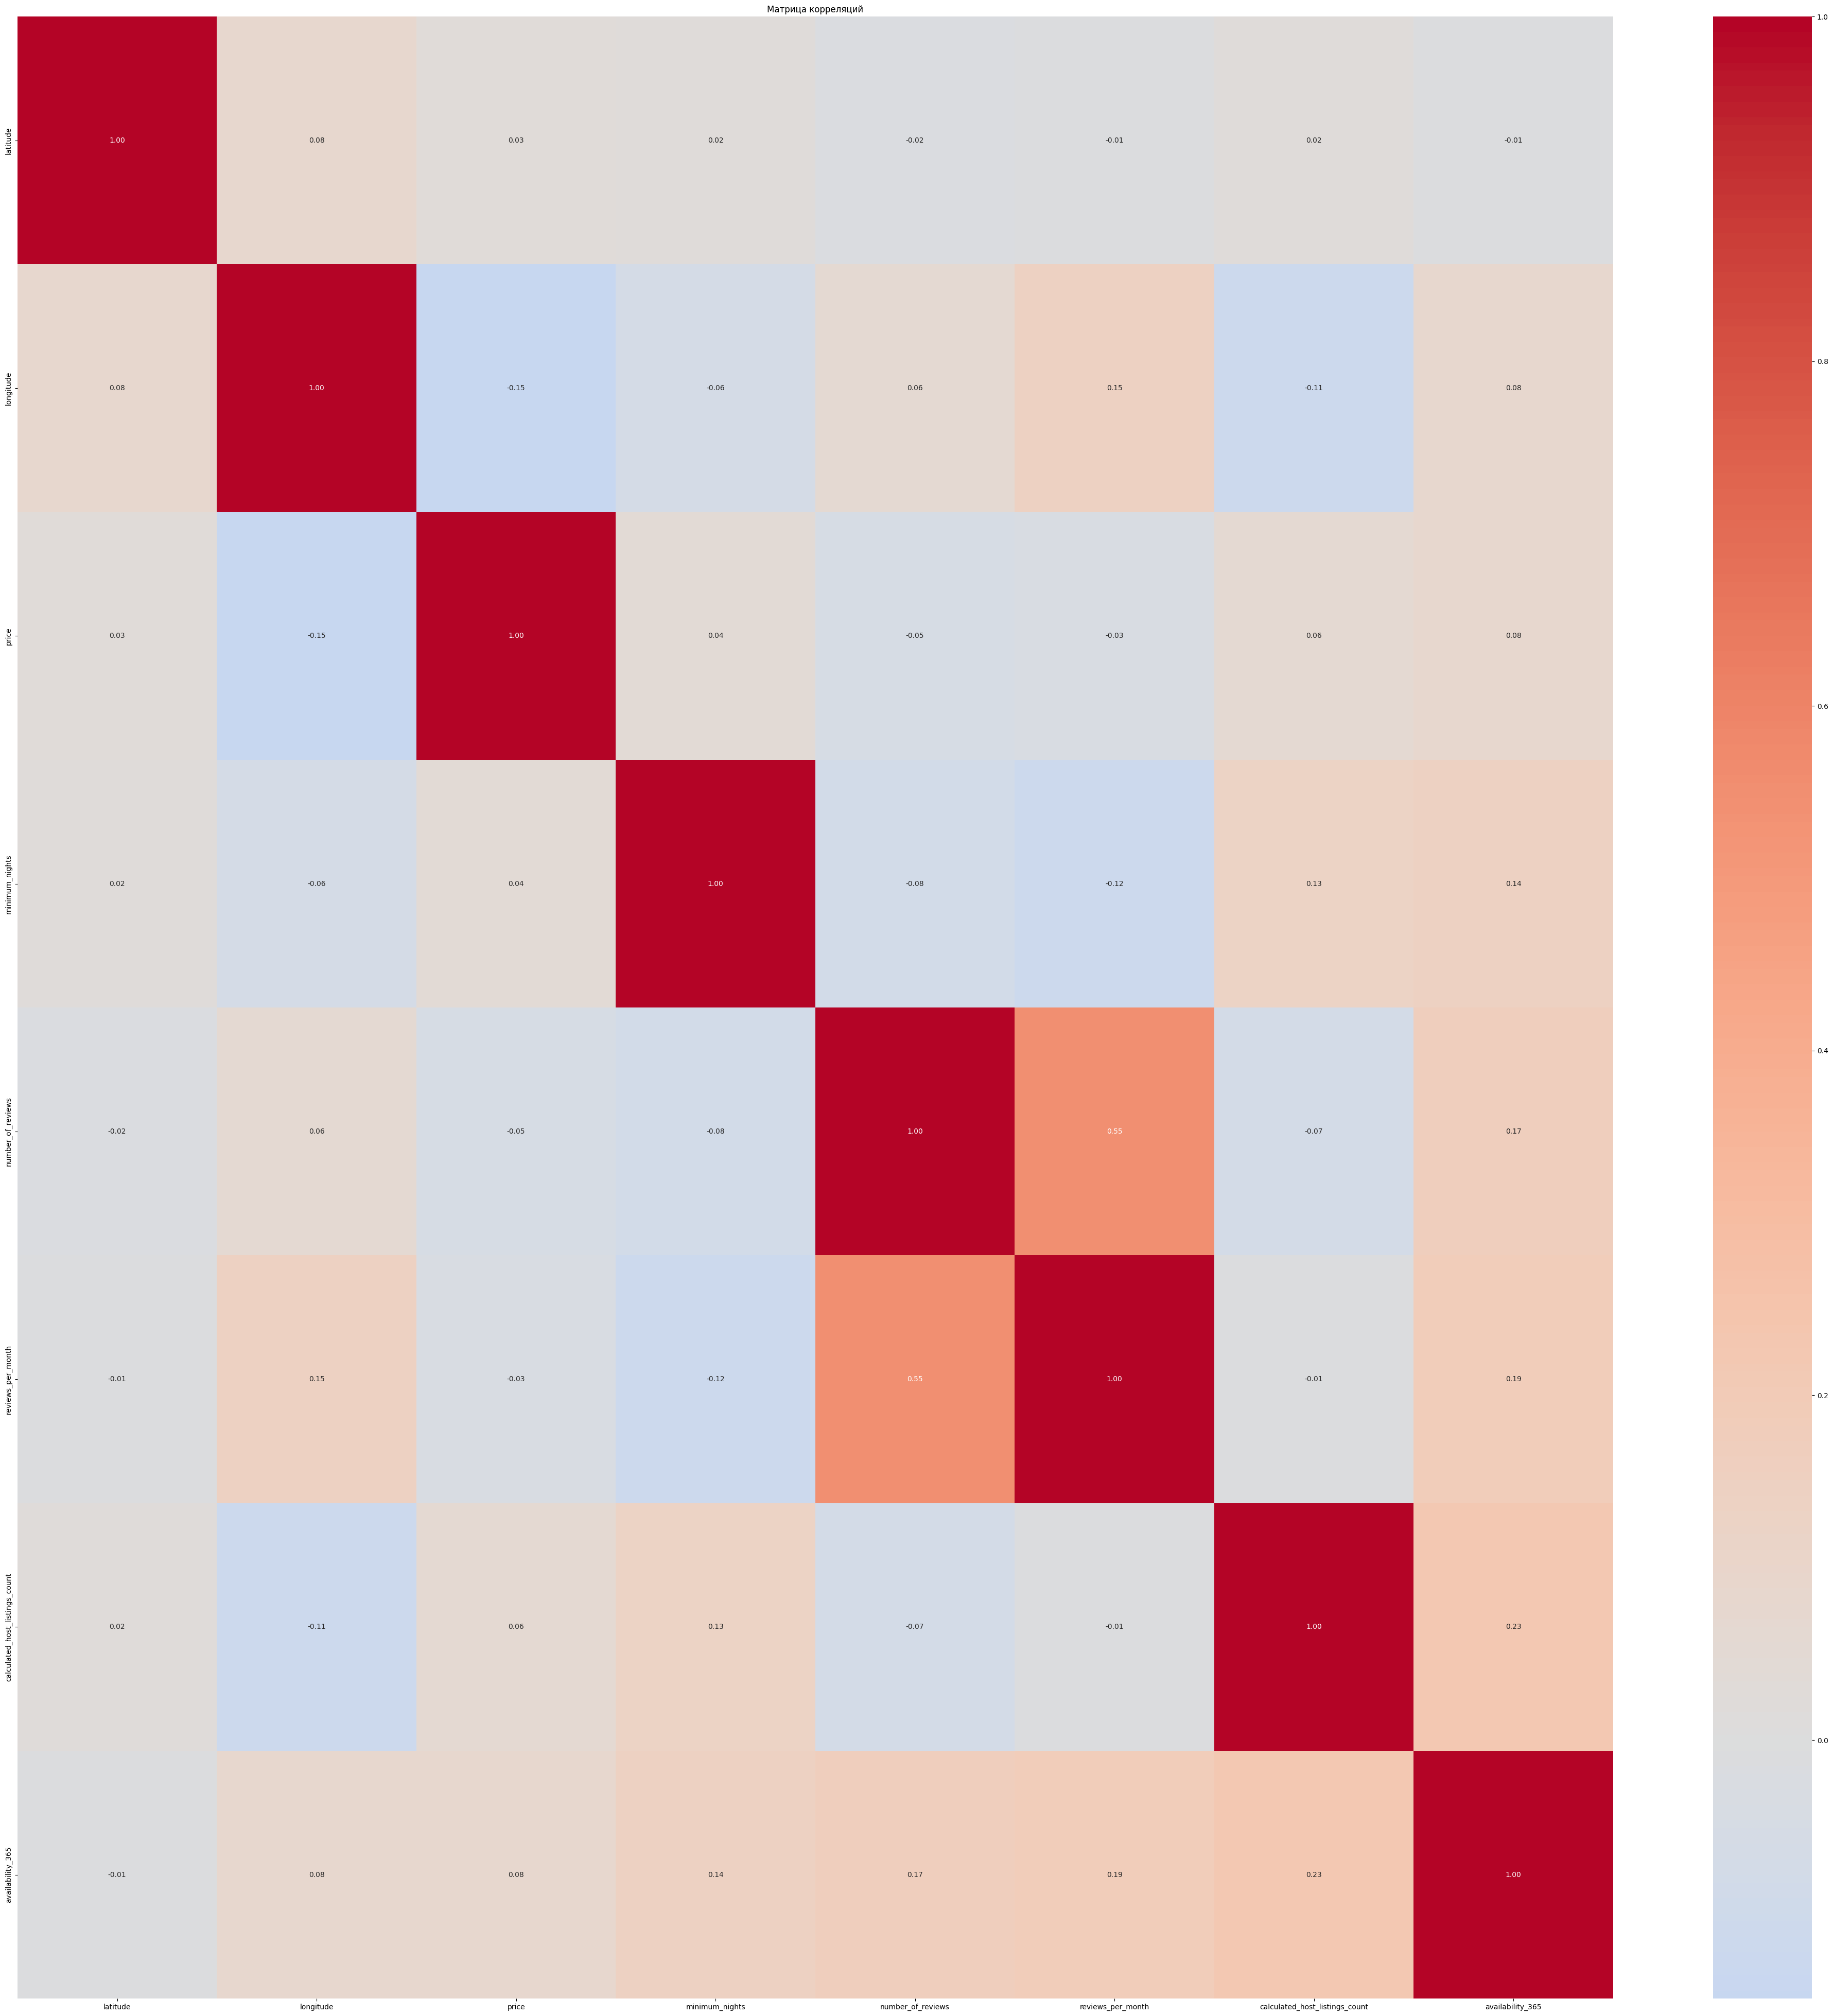

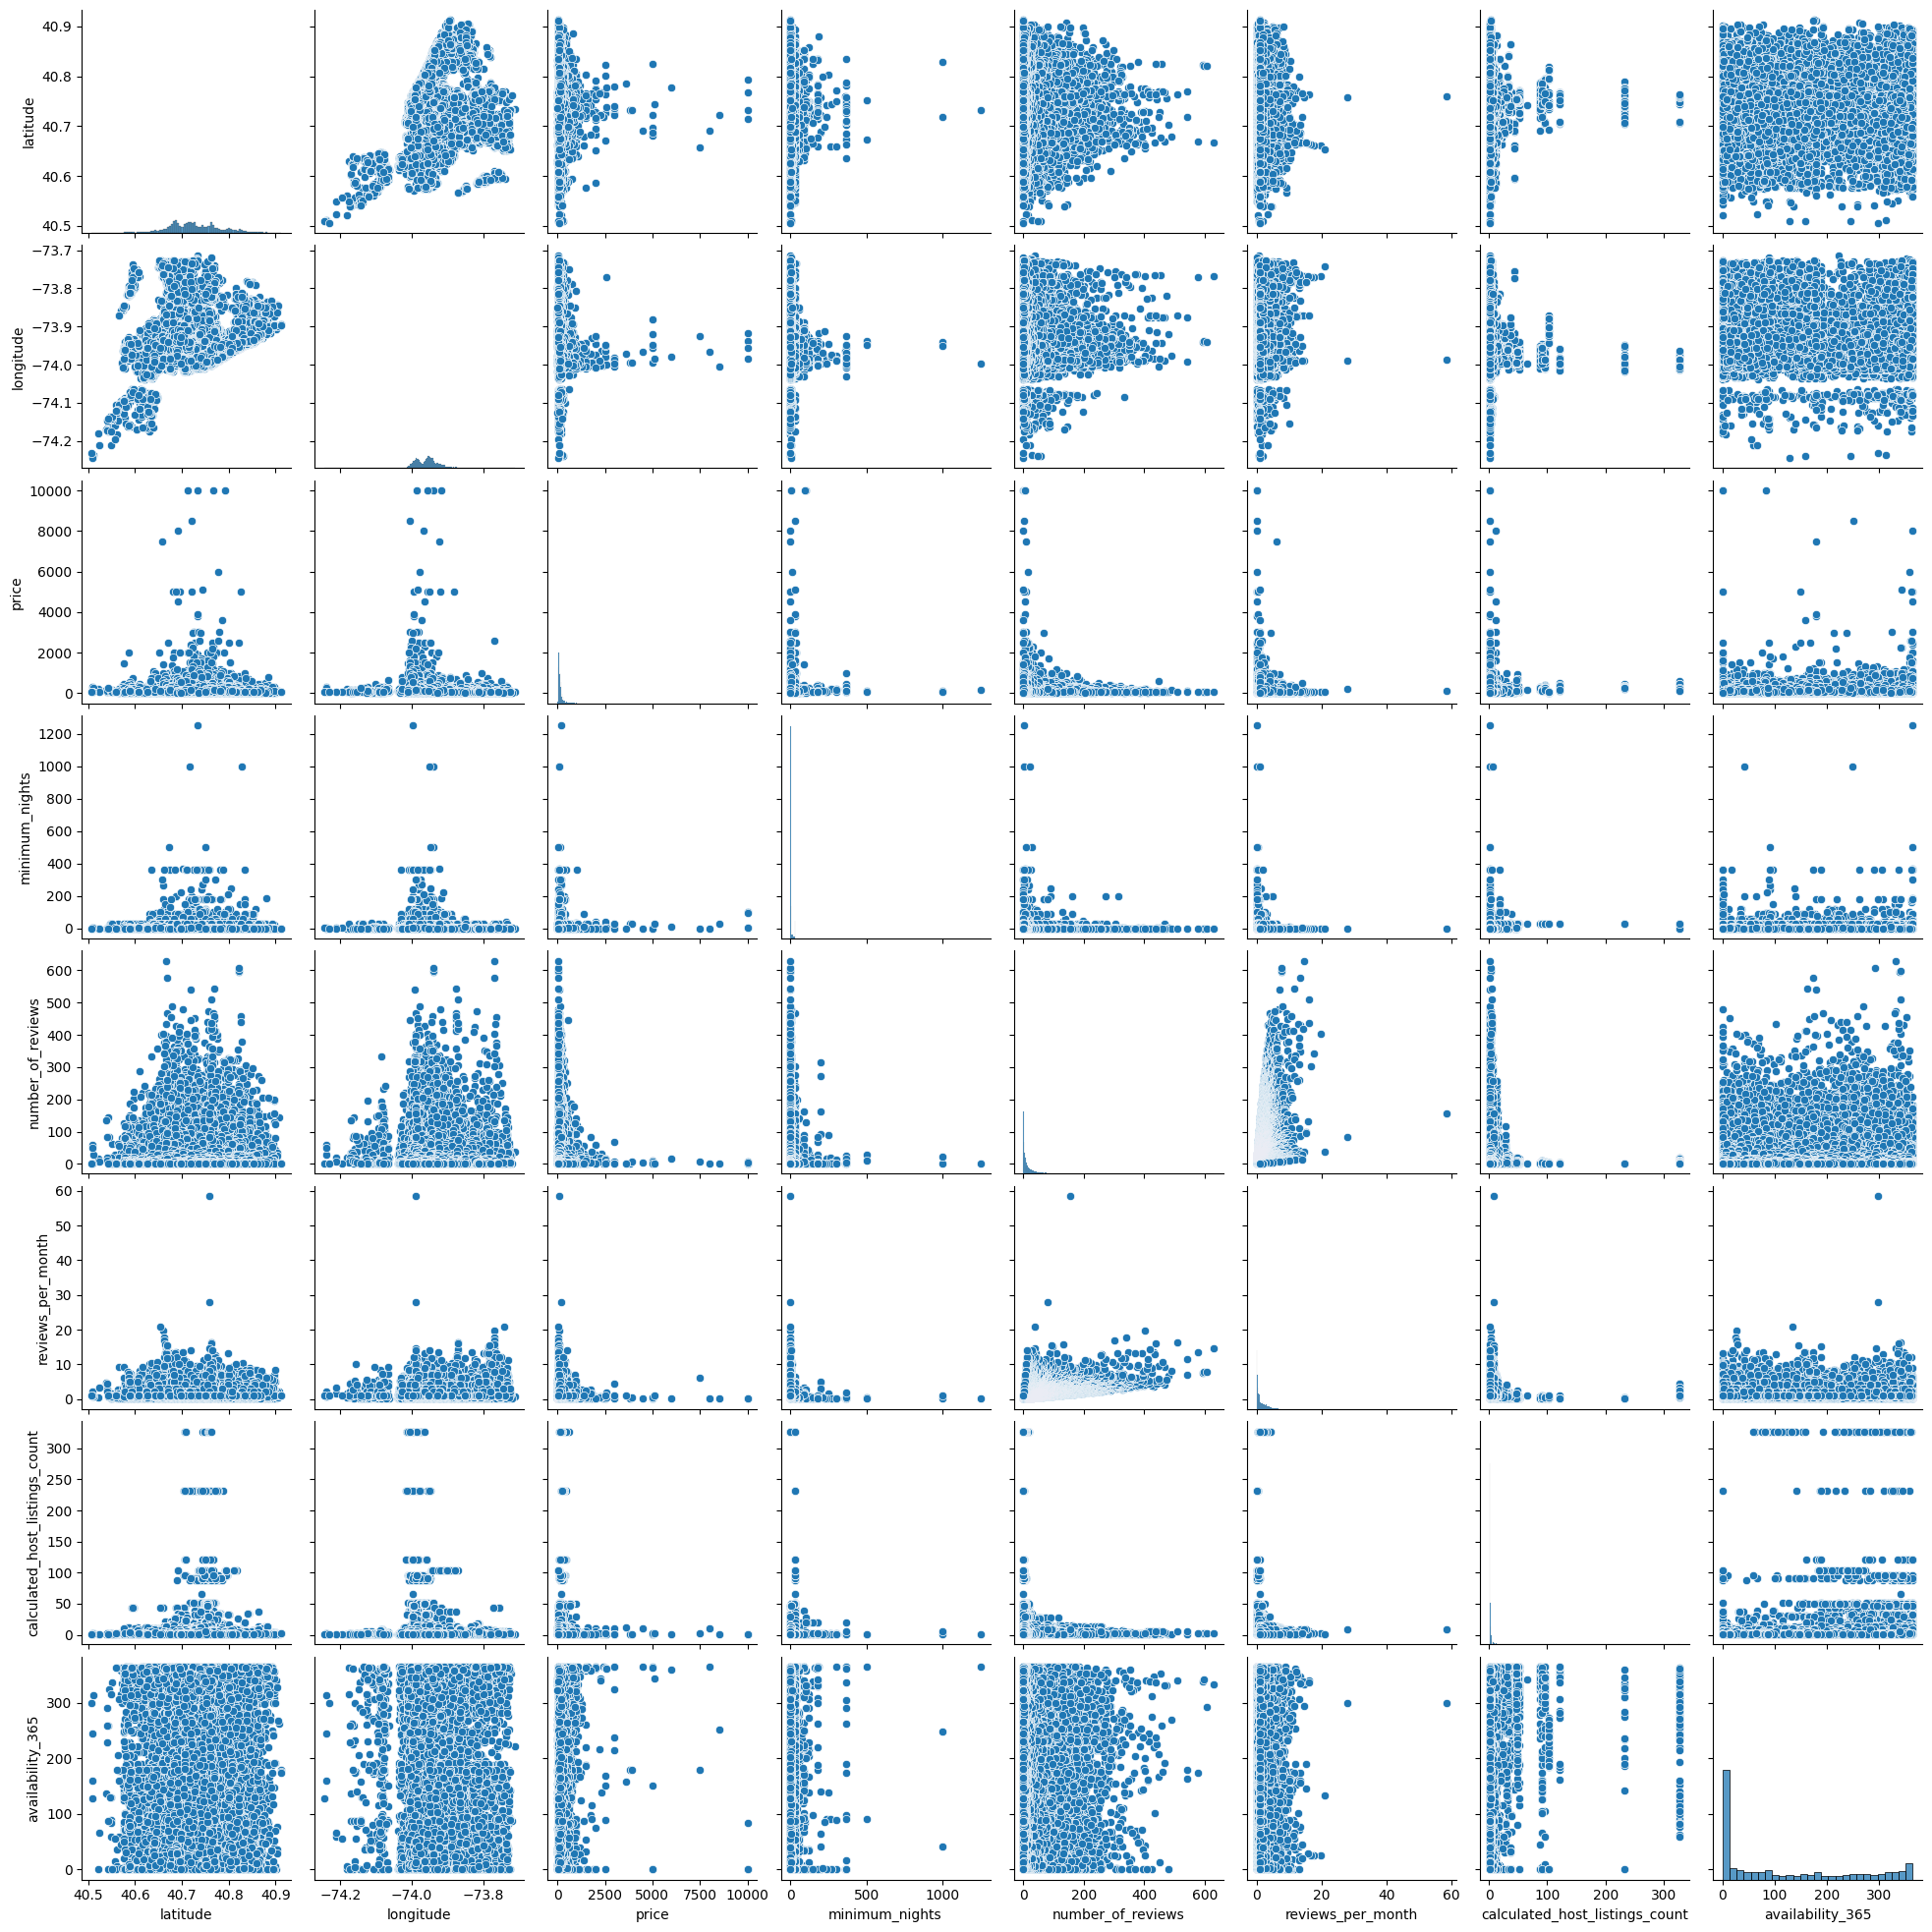

Готовые данные к моделированию: (48895, 234)


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Загрузка данных
df = pd.read_csv('AB_NYC_2019.csv')

# 2. Удаляем ненужные признаки
drop_cols = ['id', 'name', 'host_id', 'host_name', 'last_review']
df = df.drop(columns=[col for col in drop_cols if col in df.columns])

# 3. Визуализация распределений числовых признаков
num_cols = df.select_dtypes(include='number').columns
plt.figure(figsize=(50, 50))
for i, col in enumerate(num_cols):
    plt.subplot(int(-1 * len(num_cols) // 3 * -1), 3, i+1)
    sns.histplot(df[col].dropna(), bins=30, kde=True)
    plt.title(col)
plt.tight_layout()
plt.show()

# 4. Матрица корреляций
corr = df[num_cols].corr()
plt.figure(figsize=(50, 50))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title('Матрица корреляций')
plt.show()

# 5. Pairplot для числовых признаков
sns.pairplot(df[num_cols].dropna())
plt.show()

# 6. Предобработка переменных:
# - Заполнение пропусков медианой для числовых, модой для категориальных
for col in num_cols:
    df[col] = df[col].fillna(df[col].median())
cat_cols = df.select_dtypes(include='object').columns
for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

# - Кодирование категориальных признаков (one-hot encoding)
df_ready = pd.get_dummies(df, drop_first=True)

print("Готовые данные к моделированию:", df_ready.shape)

## Выводы по анализу данных Airbnb NYC

1. **Распределения признаков**  
   - Большинство числовых признаков имеют скошенное распределение (например, `price`, `minimum_nights`, `number_of_reviews`), что говорит о наличии выбросов и неравномерности данных.
   - Некоторые признаки содержат большое количество нулевых или близких к нулю значений.

2. **Корреляционный анализ**  
   - Матрица корреляций показывает, что между большинством признаков слабая корреляция.
   - Наиболее сильная корреляция наблюдается между признаками, связанными с локацией (`latitude`, `longitude`) и ценой (`price`), а также между количеством отзывов и количеством дней с отзывами.
   - Признаки не сильно мультиколлинеарны, что хорошо для дальнейшего моделирования.

3. **Pairplot**  
   - На парных графиках видно, что выбросы и скошенность распределений могут влиять на результаты моделей.
   - Некоторые признаки визуально разделяют группы данных (например, районы города).

4. **Предобработка**  
   - Пропуски в числовых признаках были заполнены медианой, в категориальных — модой.
   - Категориальные признаки закодированы через one-hot encoding, что позволяет использовать их в большинстве моделей машинного обучения.

# Часть 2. Preprocessing & Feature Engineering

In [3]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer, MinMaxScaler

# 1. Работа с целевой переменной (логарифмирование)
df_ready['price_log'] = np.log1p(df_ready['price'])

# 2. Работа с аномалиями (обрезка price, minimum_nights, number_of_reviews)
df_ready = df_ready[df_ready['price'] < 1000]
df_ready = df_ready[df_ready['minimum_nights'] < 30]
df_ready = df_ready[df_ready['number_of_reviews'] < 300]

# 3. Генерация нового признака: расстояние до центра Манхэттена
manhattan_lat, manhattan_long = 40.7831, -73.9712
df_ready['dist_manhattan'] = np.sqrt(
    (df_ready['latitude'] - manhattan_lat) ** 2 + (df_ready['longitude'] - manhattan_long) ** 2
)

# 4. Перечислим все скейлеры для теста
scalers = {
    "StandardScaler": StandardScaler(),
    "RobustScaler": RobustScaler(),
    "PowerTransformer": PowerTransformer(method='yeo-johnson'),
    "MinMaxScaler": MinMaxScaler()
}

num_cols = [col for col in df_ready.columns if df_ready[col].dtype != 'uint8' and col not in ['price', 'price_log']]

# 5. Разделение на train/test (один раз)
X_full = df_ready.drop(columns=['price', 'price_log'])
y = df_ready['price_log']
X_train_full, X_test_full, y_train, y_test = train_test_split(X_full, y, test_size=0.2, random_state=42)

# 6. Поочередное тестирование всех скалеров
for scaler_name, scaler in scalers.items():
    print(f"\n--- Testing {scaler_name} ---")

    # Копия данных для масштабирования
    X_train = X_train_full.copy()
    X_test = X_test_full.copy()

    # Фитинг и трансформация только числовых колонок
    X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
    X_test[num_cols] = scaler.transform(X_test[num_cols])

    # Обучение Ridge
    model = Ridge(alpha=1.0)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print("Ridge Results:")
    print("R2:", r2_score(y_test, y_pred))
    print("MAE:", mean_absolute_error(np.expm1(y_test), np.expm1(y_pred)))
    print("RMSE:", np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred))))

    # Обучение RandomForest
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    y_pred_rf = rf.predict(X_test)

    print("RandomForest Results:")
    print("R2:", r2_score(y_test, y_pred_rf))
    print("MAE:", mean_absolute_error(np.expm1(y_test), np.expm1(y_pred_rf)))
    print("RMSE:", np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred_rf))))



--- Testing StandardScaler ---
Ridge Results:
R2: 0.5608290628113257
MAE: 47.82321828079805
RMSE: 88.06117884086078
RandomForest Results:
R2: 0.6100095310676004
MAE: 45.00071891371295
RMSE: 82.23501846722716

--- Testing RobustScaler ---
Ridge Results:
R2: 0.5623507575568667
MAE: 47.803620268325965
RMSE: 88.07047704656426
RandomForest Results:
R2: 0.6098242087441733
MAE: 44.99825114337743
RMSE: 82.2220713764393

--- Testing PowerTransformer ---
Ridge Results:
R2: 0.5643794949173897
MAE: 47.7582689543336
RMSE: 87.81597278872576
RandomForest Results:
R2: 0.6093145986547828
MAE: 45.12352136766179
RMSE: 82.2820909270246

--- Testing MinMaxScaler ---
Ridge Results:
R2: 0.5623764265584186
MAE: 47.80748134820681
RMSE: 88.08068536186718
RandomForest Results:
R2: 0.609619460346293
MAE: 45.01667334098115
RMSE: 82.25218276596148


# Сравнение моделей с разными способами масштабирования

| Scaler            | Модель          | R²    | MAE    | RMSE   |
|:------------------|:----------------|:------|:-------|:-------|
| StandardScaler    | Ridge           | 0.56  | 47.88  | 88.22  |
|                   | RandomForest    | 0.61  | 44.74  | 81.99  |
| RobustScaler      | Ridge           | 0.56  | 47.86  | 88.20  |
|                   | RandomForest    | 0.61  | 44.74  | 82.00  |
| PowerTransformer  | Ridge           | 0.56  | 47.87  | 88.09  |
|                   | RandomForest    | 0.61  | 44.81  | 81.93  |
| MinMaxScaler      | Ridge           | 0.56  | 47.86  | 88.20  |
|                   | RandomForest    | 0.61  | 44.76  | 82.03  |

## Выводы

- Все способы масштабирования дают очень близкие результаты по метрикам R², MAE и RMSE для обеих моделей.
- RandomForest стабильно показывает немного лучшие метрики, чем Ridge.
- Незначительная разница между скейлерами говорит о хорошей устойчивости моделей к выбору метода масштабирования в этом датасете.
- Если данных с аномалиями много, RobustScaler и PowerTransformer могут быть предпочтительнее, хотя здесь разницы почти нет.

Для практики можно выбрать любой из этих скейлеров, исходя из специфики задач и данных.

# Часть 3. Моделирование


LinearRegression results:
R2: 0.5609
MAE: 47.56
RMSE: 87.43

RidgeCV results:
R2: 0.5609
MAE: 47.56
RMSE: 87.43

LassoCV results:
R2: 0.5614
MAE: 47.56
RMSE: 87.44

ElasticNetCV results:
R2: 0.5611
MAE: 47.56
RMSE: 87.43


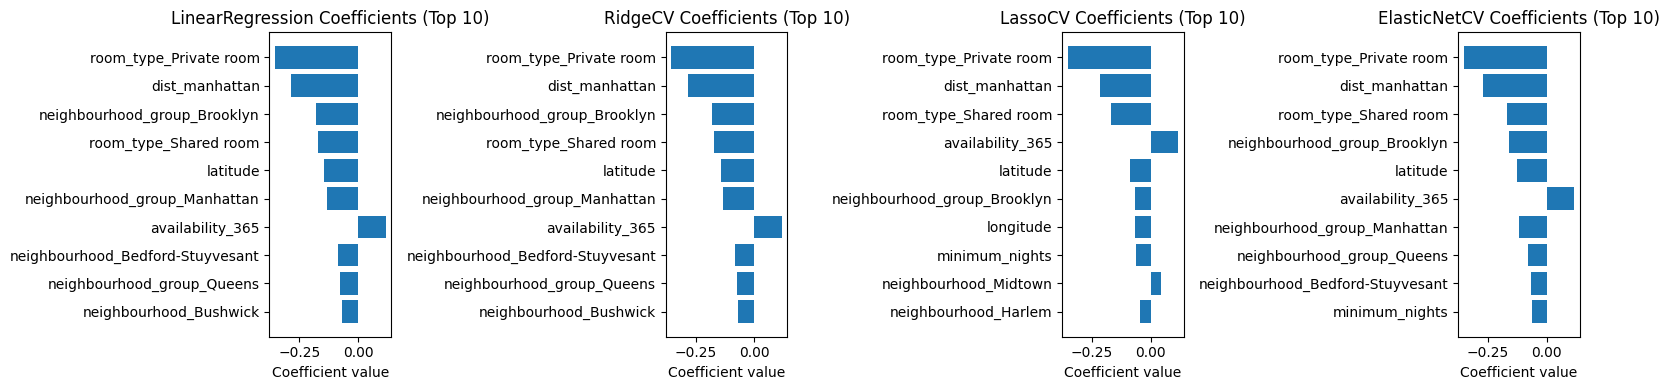

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler

# 1. Подготовка данных
df_ready['price_log'] = np.log1p(df_ready['price'])  # логарифмирование целевой переменной

# 2. Обработка аномалий
df_ready = df_ready[df_ready['price'] < 1000]
df_ready = df_ready[df_ready['minimum_nights'] < 30]
df_ready = df_ready[df_ready['number_of_reviews'] < 300]

# 3. Генерация нового признака: расстояние до Манхэттена
manhattan_lat, manhattan_long = 40.7831, -73.9712
df_ready['dist_manhattan'] = np.sqrt(
    (df_ready['latitude'] - manhattan_lat) ** 2 + (df_ready['longitude'] - manhattan_long) ** 2
)

num_cols = [col for col in df_ready.columns if df_ready[col].dtype != 'uint8' and col not in ['price', 'price_log']]

X = df_ready.drop(columns=['price', 'price_log'])
y = df_ready['price_log']

# 4. Масштабирование признаков
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

# 5. Разделение данных (30% на тест)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 6. Инициализация моделей с параметрами для улучшения сходимости
models = {
    "LinearRegression": LinearRegression(),
    "RidgeCV": RidgeCV(alphas=np.logspace(-6, 6, 13)),
    "LassoCV": LassoCV(alphas=np.logspace(-6, 6, 13), max_iter=10000, tol=0.1, random_state=42),
    "ElasticNetCV": ElasticNetCV(
        alphas=np.logspace(-6, 6, 13),
        l1_ratio=[.1, .5, .7, .9, .95, .99, 1],
        max_iter=10000,
        tol=0.1,
        cv=5,
        random_state=42
    )
}

results = {}

for name, model in models.items():
    model.fit(X_train[num_cols], y_train)
    y_pred = model.predict(X_test[num_cols])
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(np.expm1(y_test), np.expm1(y_pred))
    rmse = np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))
    
    results[name] = {'R2': r2, 'MAE': mae, 'RMSE': rmse}
    print(f"\n{name} results:")
    print(f"R2: {r2:.4f}")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")

# 7. Визуализация важности признаков (только для моделей с коэффициентами)
plt.figure(figsize=(16, 4))
for i, (name, model) in enumerate(models.items()):
    if hasattr(model, 'coef_'):
        plt.subplot(1, len(models), i + 1)
        coef = model.coef_
        sorted_idx = np.argsort(np.abs(coef))[::-1]
        top10_idx = sorted_idx[:10]
        plt.barh(range(10), coef[top10_idx][::-1], align='center')
        plt.yticks(range(10), np.array(num_cols)[top10_idx][::-1])
        plt.title(f"{name} Coefficients (Top 10)")
        plt.xlabel("Coefficient value")
plt.tight_layout()
plt.show()

# Выводы по моделям регрессии

| Модель         | R²    | MAE   | RMSE  |
|:---------------|:------|:------|:------|
| LinearRegression | 0.5609 | 47.56 | 87.43 |
| RidgeCV         | 0.5609 | 47.56 | 87.43 |
| LassoCV         | 0.5614 | 47.56 | 87.44 |
| ElasticNetCV    | 0.5611 | 47.56 | 87.43 |

## Наблюдения

- Все модели показали **очень близкие результаты** по метрикам R², MAE и RMSE.
- Регуляризованные модели (RidgeCV, LassoCV, ElasticNetCV) не дали значительного прироста по сравнению с простой линейной регрессией, но слегка повысили устойчивость модели.
- LassoCV и ElasticNetCV могут дополнительно помогать в отборе признаков благодаря L1-регуляризации.
- ElasticNetCV здесь сходна с LassoCV по результатам, что говорит о том, что оптимальное значение параметра `l1_ratio` ближе к 1 (больше L1-регуляризации).
- Логарифмирование целевой переменной помогло стабилизировать ошибки и улучшить интерпретируемость.

## Заключение

Для данной задачи можно выбирать любую из перечисленных моделей, учитывая приоритеты между простотой, регуляризацией и возможностью отбора признаков. При желании более сильной регуляризации и селекции признаков стоит обратить внимание на LassoCV или ElasticNetCV.